In [1]:
import pandas as pd
import random
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

import os
import sys
import warnings

import skbio
from sklearn.metrics import mean_squared_error
from scipy import stats
from sklearn.preprocessing import StandardScaler

In [2]:
warnings.filterwarnings("ignore")

In [3]:
MODULE_PATH = os.path.abspath('/storage/zkarwowska/SONATA_PROJECT/clean_code/data_preparation/') 
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)

from processing import MicrobiomeDataPreprocessing, CLRTransformer, MicrobiomeTraintestSplit

MODULE_PATH = os.path.abspath('/storage/zkarwowska/SONATA_PROJECT/clean_code/data_exploration/') 
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)

from ExploreTS import TestStationarity, MakeSeriesStationary, AutoCorrelation

MODULE_PATH = os.path.abspath('/storage/zkarwowska/SONATA_PROJECT/clean_code/helper_functions/') 
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)

from regression_models import *

In [4]:
file = '/storage/zkarwowska/microbiome-interactions/datasets/processed/ready_datasets/donorA_rarefied_interpolated_feces.csv'

#### 1. READ DATA

In [5]:
df = pd.read_csv(file, index_col = [0])
df.shape

(365, 1531)

#### 2. FILTER RARE BACTERIA

In [6]:
processing = MicrobiomeDataPreprocessing()
df_filtered = processing.filter_rare_features(df, treshold_perc = .9)
df_filtered.shape

(365, 205)

#### 3. CALCULATE SHANNON DIVERSITY INDEX FOR EACH TIMEPOINT

In [7]:
def calculate_shannon(df):
    
    SHANNON_IDX = []
    for i in range(len(df.index)):
        x = df.iloc[i].values
        shannon_idx = skbio.diversity.alpha.shannon(x)
        
        SHANNON_IDX.append(shannon_idx)
        
    shannon_df = pd.DataFrame(SHANNON_IDX, columns = ['shannon_idx'])
    
    return shannon_df

In [8]:
shannon_idx = calculate_shannon(df_filtered)
shannon_idx.head()

,shannon_idx
0,4.169125
1,4.284418
2,4.231103
3,4.231103
4,3.801097


<AxesSubplot:xlabel='shannon_idx', ylabel='Density'>

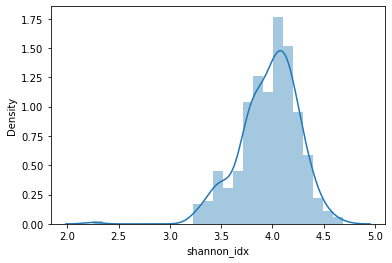

In [9]:
sns.distplot(shannon_idx['shannon_idx'])

<AxesSubplot:ylabel='shannon_idx'>

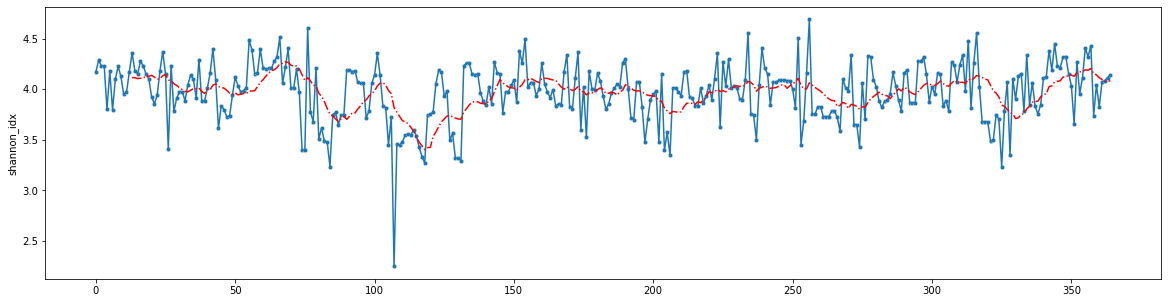

In [10]:
mv_avg = shannon_idx.rolling(window = 14).mean()

plt.figure(figsize = (20, 5))

sns.lineplot(x = shannon_idx.index, y = shannon_idx['shannon_idx'])
sns.scatterplot(x = shannon_idx.index, y = shannon_idx['shannon_idx'], s = 20)
sns.lineplot(x = mv_avg.index, y = mv_avg['shannon_idx'], color = 'red', linestyle = '-.')



#### 4. TEST IF SHANNON IDX IS STATIONARY

In [11]:
stationary_test = TestStationarity()
stationary_test.calculate_adf(shannon_idx)

,adf_pval,feature,adf_stationarity
0,0.000239,shannon_idx,stationary


In [12]:
stationary_test.calculate_kpss(np.log(shannon_idx))

,kpss_pval,feature,kpss_stationarity
0,0.063511,shannon_idx,stationary


#### 5. TEST IF SHANNON IS WHITE NOISE. OR RANDOM WALK

In [13]:
mikro_process = MicrobiomeDataPreprocessing()
_, wn, rw = mikro_process.filter_random_features(shannon_idx)

#### 6. TEST IF VARIABLE IS AUTOCORRELATED

In [14]:
#detrend as trend can mess up autocorrelation

make_stat = MakeSeriesStationary()
detrended_shannon = make_stat.remove_trend(shannon_idx)

test_autocorr = AutoCorrelation(lags=150)

acf_df = test_autocorr.calculate_acf(detrended_shannon)
pacf_df = test_autocorr.calculate_pacf(detrended_shannon)

<AxesSubplot:xlabel='lag', ylabel='coeff'>

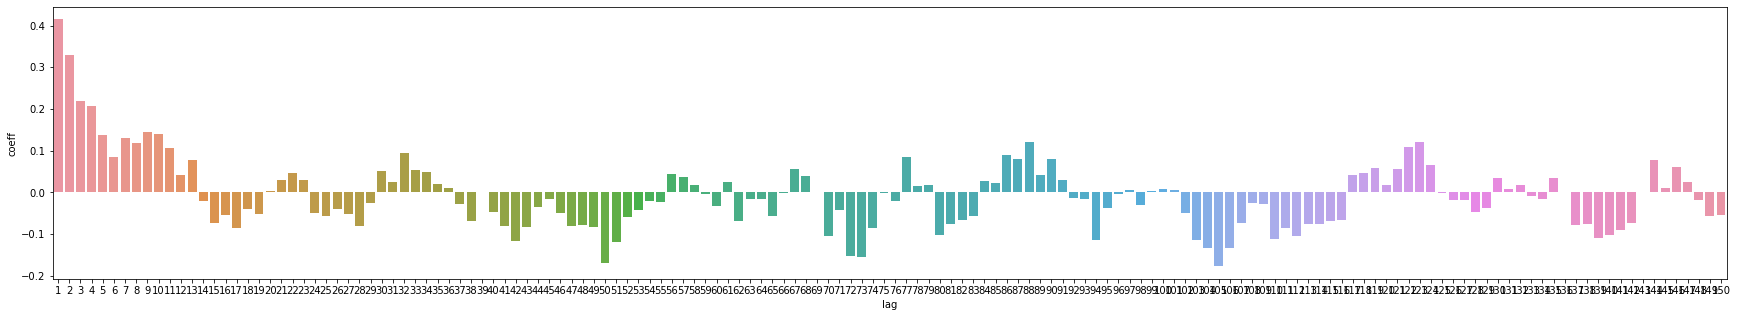

In [15]:
plt.figure(figsize = (30, 5))
sns.barplot(data = acf_df, x = 'lag', y = 'coeff')

<AxesSubplot:xlabel='lags', ylabel='coeff'>

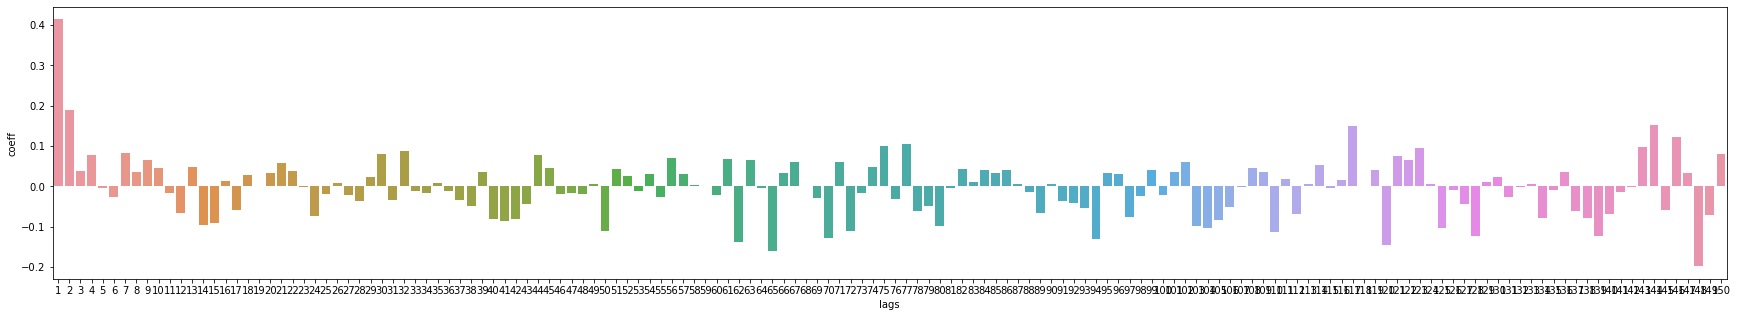

In [16]:
plt.figure(figsize = (30, 5))
sns.barplot(data = pacf_df, x = 'lags', y = 'coeff')

#### 7.MODEL

In [19]:
def test_lag_prediction(lag, df):
    
    #change to supervised
    lag = lag
    df_supervised = processing.make_supervised(df, maxlag = lag)
    
    # split to train and test
    split = MicrobiomeTraintestSplit(prc_split=0.1)
    train, test = split.last_block_split(df_supervised)
    train, test = train.sort_index(), test.sort_index()
    
    # fit model
    
    ridge_model = RidgeModel(1)
    y_pred, model = ridge_model.test_model(train, test)

    # define true and naive
    
    y_true = test['shannon_idx_lag0']
    idx = range(len(y_true))
    naive = df.iloc[-(test.shape[0]+lag):-lag]
    
    # measure error
    rmse = np.round(mean_squared_error(y_true.values, y_pred.values, squared=False), 3)
    corr = np.round(stats.spearmanr(y_true.values, y_pred[0].values)[0], 3)
    
    # plot
    plt.figure(figsize = [15, 5])
    sns.lineplot(x = idx, y = y_true.values, color= 'black')
    sns.scatterplot(x = idx, y = y_true.values, color= 'black')

    sns.lineplot(x = idx, y = y_pred.iloc[:, 0].values, color= 'orange')
    sns.scatterplot(x = idx, y = y_pred.iloc[:, 0].values, color= 'orange')
    
    sns.lineplot(x = idx, y = naive.iloc[:,0].values, color= 'green', linestyle = '-.', linewidth = .5)
    #sns.scatterplot(x = idx, y = naive.iloc[:,0].values, color= 'green')
    
    plt.title('lag= {}, rmse= {}, corr= {}'.format(lag, rmse, corr))
    
    plt.show()
    
    return model
    

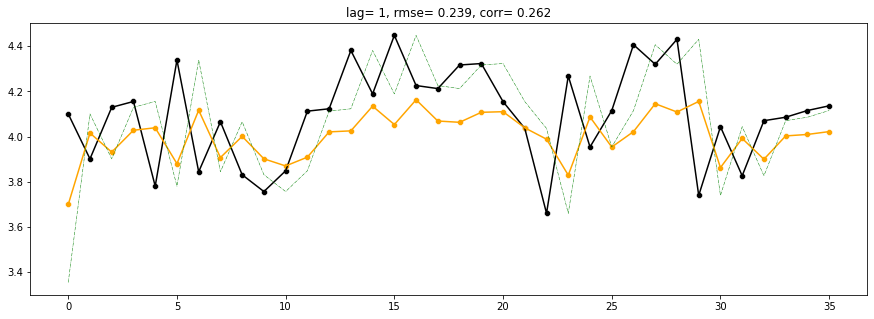

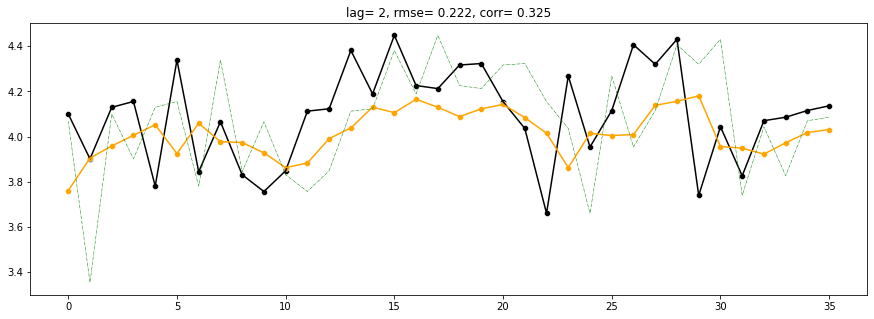

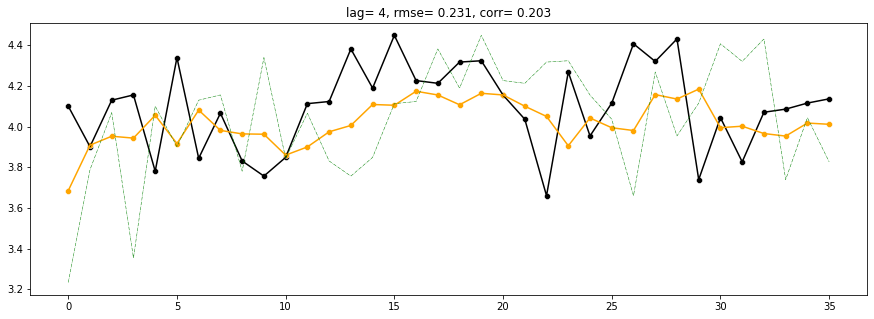

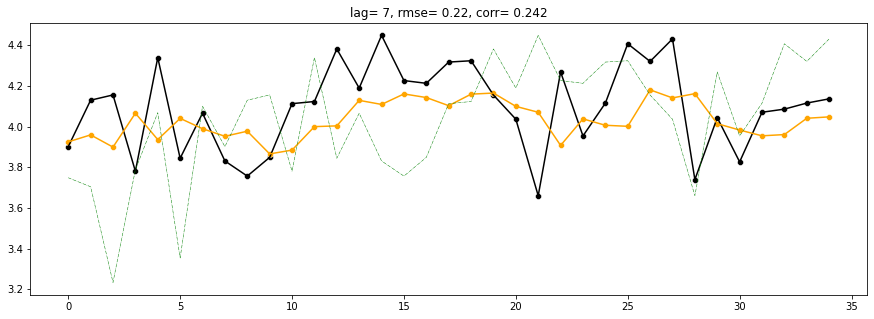

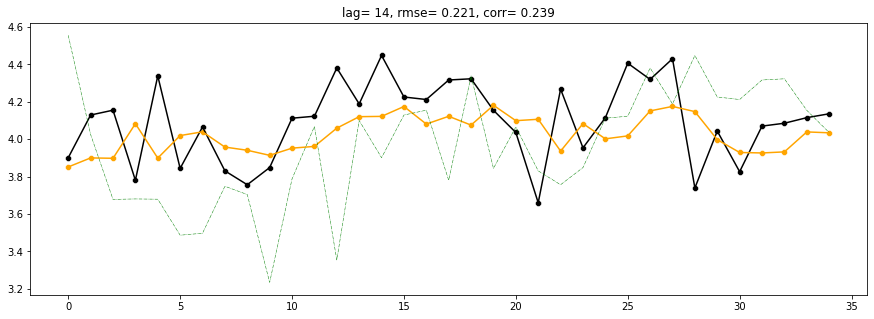

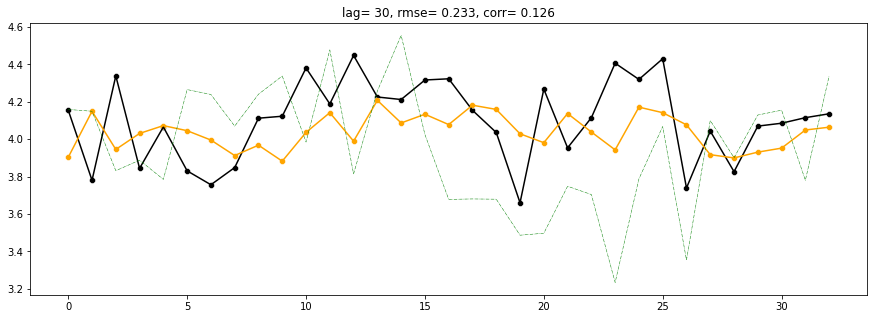

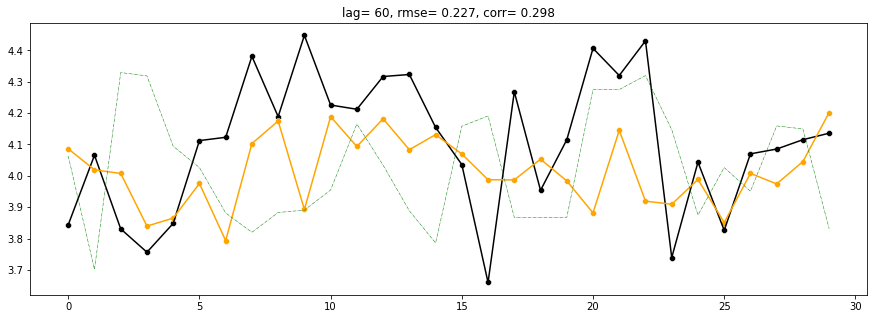

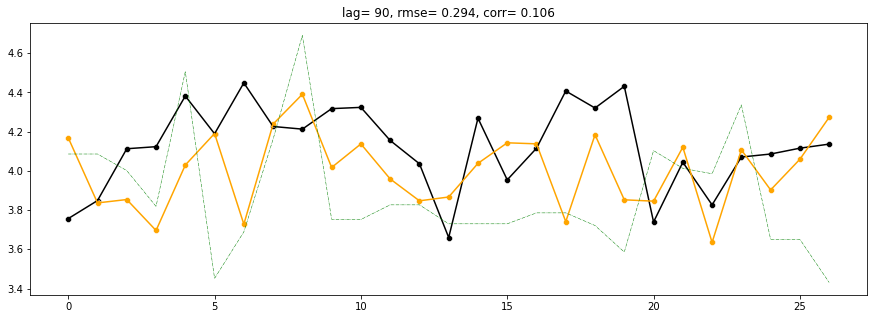

In [28]:
lags = [1, 2, 4, 7, 14, 30, 60, 90]

for lag in lags:
    
    test_lag_prediction(lag, shannon_idx)